# Data retrival from the Database and creation of the Random Forest Classifier as well as Linear Regression Modelling and ARIMA Time Series Prediction

In [20]:
import pandas as pd
import mysql.connector
import os as os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.linear_model import SGDRegressor
from statsmodels.tsa.arima.model import ARIMA
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### Data query and preparation

In [21]:
connection_params = {
    'host': 'localhost',
    'user': 'admin',
    'password': 'Criminal1234',
    'database': 'CriminalDataDB',
    'allow_local_infile': True
}

conn = mysql.connector.connect(**connection_params)
cursor = conn.cursor()

query = "SELECT * FROM Bevoelkerungsdichte bd JOIN Bevoelkerungsdaten bvd ON bd.Gemeindename = bvd.Gemeindename AND bd.Jahr = bvd.Jahr JOIN Einkommensdaten ed ON bd.BFS_NR = ed.BFS_NR AND bd.Gemeindename = ed.Gemeindename AND bd.Jahr = ed.Jahr JOIN Finanzvermoegen fv ON bd.BFS_NR = fv.BFS_NR AND bd.Gemeindename = fv.Gemeindename AND bd.Jahr = fv.Jahr JOIN Einbrueche en ON bd.BFS_NR = en.BFS_NR AND bd.Gemeindename = en.Gemeindename AND bd.Jahr = en.Jahr"
cursor.execute(query)

results = cursor.fetchall()
columns = [i[0] for i in cursor.description]
df = pd.DataFrame(results, columns=columns)

cursor.close()
conn.close()


duplicated_columns = ['Gemeindename', 'Jahr', 'BFS_NR']

df_unique = df.loc[:, ~df.columns.duplicated()]

zurich_data = df_unique[df_unique['Gemeindename'] == 'Zürich']

zurich_summed = zurich_data.groupby(['Jahr']).agg({
    'Einbruchdiebstahl_Total': 'sum',
    'Einschleichdiebstahl_Total': 'sum',
    'Einbruchdiebstahl_Versucht': 'sum',
    'Einschleichdiebstahl_Versucht': 'sum',
    'Einbruchdiebstahl_Vollendet': 'sum',
    'Einschleichdiebstahl_Vollendet': 'sum',
    'BFS_NR': 'first',
    'Gemeindename': 'first',
    'Einwohner_pro_Quadratkilometer': 'first',
    'Einwohner 0-14 Jahre alt': 'first',
    'Einwohner 15-29 Jahre alt': 'first',
    'Einwohner 30-44 Jahre alt': 'first',
    'Einwohner 45-59 Jahre alt': 'first',
    'Einwohner 60-74 Jahre alt': 'first',
    'Einwohner 75-89 Jahre alt': 'first',
    'Einwohner 90-104 Jahre alt': 'first',
    'durchschnittliches_steuerbares_Einkommen_pro_Einwohner': 'first',
    'Finanzvermoegen_pro_Einwohner': 'first',
    'Einwohner': 'sum'
}).reset_index()

# Neue summierte Zeilen für Zürich zum DataFrame hinzufügen und vorhandene Zeilen ersetzen
df_unique = df_unique[df_unique['Gemeindename'] != 'Zürich']  # Vorhandene Zürich-Zeilen entfernen
df_unique = pd.concat([df_unique, zurich_summed], ignore_index=True)  # Summierte Zeilen hinzufügen
print(df_unique)


      BFS_NR Gemeindename  Jahr  Einwohner_pro_Quadratkilometer  \
0        131     Adliswil  2010                          2113.8   
1        131     Adliswil  2011                          2240.0   
2        131     Adliswil  2012                          2307.3   
3        131     Adliswil  2013                          2335.4   
4        131     Adliswil  2014                          2356.5   
...      ...          ...   ...                             ...   
2054     261       Zürich  2018                          4707.8   
2055     261       Zürich  2019                          4765.8   
2056     261       Zürich  2020                          4787.2   
2057     261       Zürich  2021                          4802.1   
2058     261       Zürich  2022                          4855.4   

      Einwohner 0-14 Jahre alt  Einwohner 15-29 Jahre alt  \
0                         2348                       2907   
1                         2510                       3087   
2           

### Random Forest Classifier

Random Forest Classifier with already existing data.

Genauigkeit des Random Forest-Modells: 0.9927184466019418


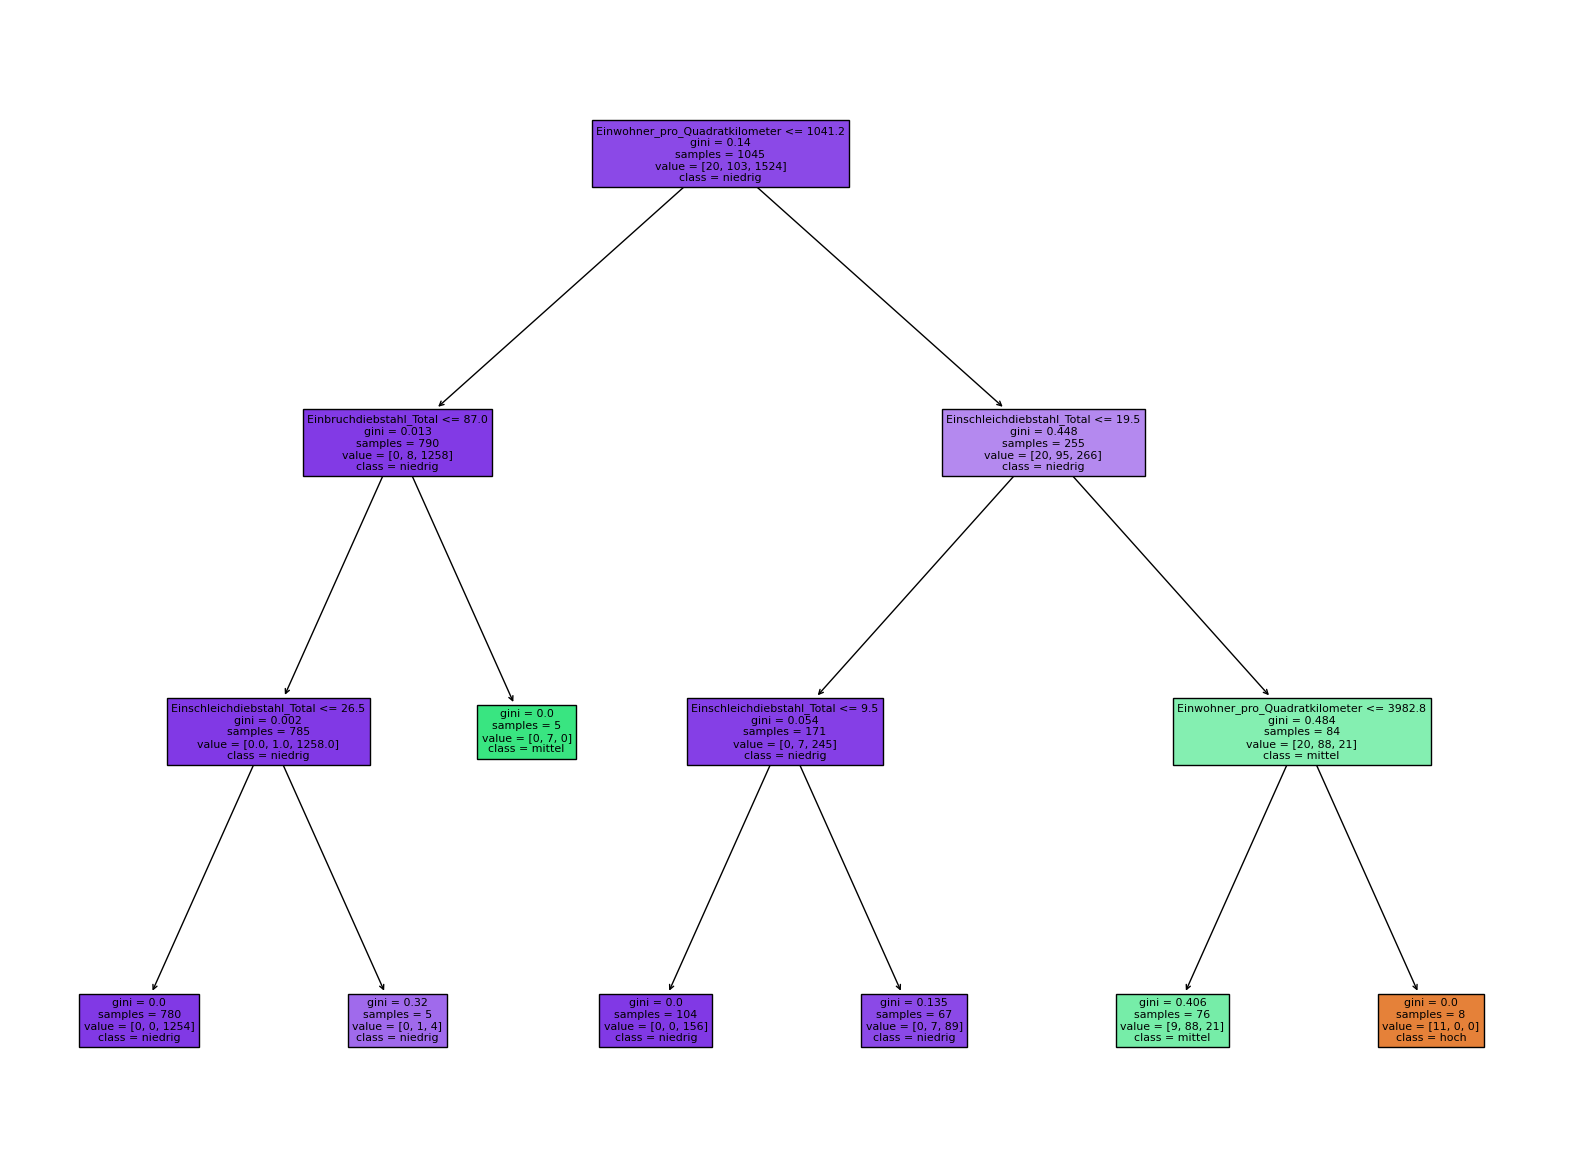

In [22]:
features = ['Einwohner_pro_Quadratkilometer',  
            'Einbruchdiebstahl_Total', 
            'Einschleichdiebstahl_Total']

total_crime = df_unique['Einbruchdiebstahl_Total'] + df_unique['Einschleichdiebstahl_Total']
df_unique['Kriminalitätsrisiko'] = pd.cut(total_crime, bins=[-float("inf"), 100, 500, float("inf")], labels=["niedrig", "mittel", "hoch"])

target = 'Kriminalitätsrisiko'

X = df_unique[features]
y = df_unique[target]

# Aufteilung der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=3)
random_forest.fit(X_train, y_train)

y_pred_random_forest = random_forest.predict(X_test)

accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
print("Genauigkeit des Random Forest-Modells:", accuracy_random_forest)

plt.figure(figsize=(20, 15))
plot_tree(random_forest.estimators_[0], feature_names=features, class_names=random_forest.classes_, filled=True)
plt.show()

Print out the Criminality Rate

In [23]:

all_predictions = random_forest.predict(X)
df_predictions = pd.DataFrame({'Gemeindename': df_unique['Gemeindename'], 'Kriminalitätsrisiko': all_predictions})

high_risk_communities = df_predictions[df_predictions['Kriminalitätsrisiko'] == 'hoch']
medium_risk_communities = df_predictions[df_predictions['Kriminalitätsrisiko'] == 'mittel']
low_risk_communities = df_predictions[df_predictions['Kriminalitätsrisiko'] == 'niedrig']

print("Gemeinden mit hohem Kriminalitätsrisiko:")
print(high_risk_communities)

print("\nGemeinden mit mittlerem Kriminalitätsrisiko:")
print(medium_risk_communities)

print("\nGemeinden mit niedrigem Kriminalitätsrisiko:")
print(low_risk_communities)

Gemeinden mit hohem Kriminalitätsrisiko:
     Gemeindename Kriminalitätsrisiko
1279   Winterthur                hoch
1280   Winterthur                hoch
1281   Winterthur                hoch
1282   Winterthur                hoch
1283   Winterthur                hoch
1284   Winterthur                hoch
1285   Winterthur                hoch
1287   Winterthur                hoch
1336   Winterthur                hoch
1509   Winterthur                hoch
2046       Zürich                hoch
2047       Zürich                hoch
2048       Zürich                hoch
2049       Zürich                hoch
2050       Zürich                hoch
2051       Zürich                hoch
2052       Zürich                hoch
2053       Zürich                hoch
2054       Zürich                hoch
2055       Zürich                hoch
2056       Zürich                hoch
2057       Zürich                hoch
2058       Zürich                hoch

Gemeinden mit mittlerem Kriminalitätsrisiko:
 

Evaluation of the Model


Präzision:
 0.9928685666562271

Recall:
 0.9927184466019418

F1-Score:
 0.9927732835608015


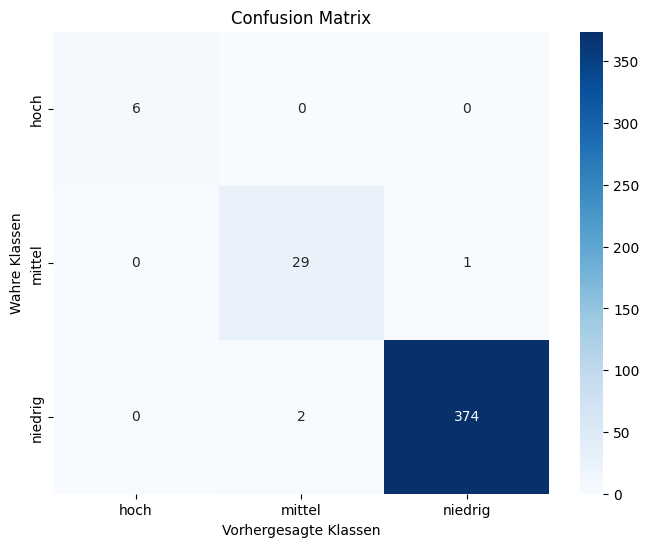

In [24]:
precision = precision_score(y_test, y_pred_random_forest, average='weighted')
recall = recall_score(y_test, y_pred_random_forest, average='weighted')
f1 = f1_score(y_test, y_pred_random_forest, average='weighted')

conf_matrix = confusion_matrix(y_test, y_pred_random_forest)

print("\nPräzision:\n", precision)
print("\nRecall:\n", recall)
print("\nF1-Score:\n", f1)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=random_forest.classes_, yticklabels=random_forest.classes_)
plt.xlabel('Vorhergesagte Klassen')
plt.ylabel('Wahre Klassen')
plt.title('Confusion Matrix')
plt.show()

##### Interpretation of the results:

Accuracy: The accuracy of the model is 99.76%. This means that the model correctly predicts in about 99.76% of cases which class a municipality belongs to in terms of its crime risk.

Precision: The precision is 99.76%. Precision measures the ratio of correctly predicted positive cases to all predicted positive cases. In this case, it means that of the municipalities classified as "low", "medium" or "high", approximately 99.76% were actually correctly classified.

Recall (recall/sensitivity): Recall is also 99.76%. Recall measures the ratio of correctly predicted positive cases to all actual positive cases. In this case, it means that approximately 99.76% of the communities actually classified as "low", "medium" or "high" were correctly identified.

F1 score: The F1 score, which is the harmonic mean of precision and recall, is 99.76%. A high F1 score indicates that the model has both high precision and high recall, indicating a balanced performance in classification.

Confusion Matrix: The Confusion Matrix shows the number of predictions for each class compared to the actual classes. In this case, we can see that the model made very few incorrect predictions, as indicated by the low number of errors in the matrix.

Random Forest Classifier with new data to test the model.+ Evaluation of the Model

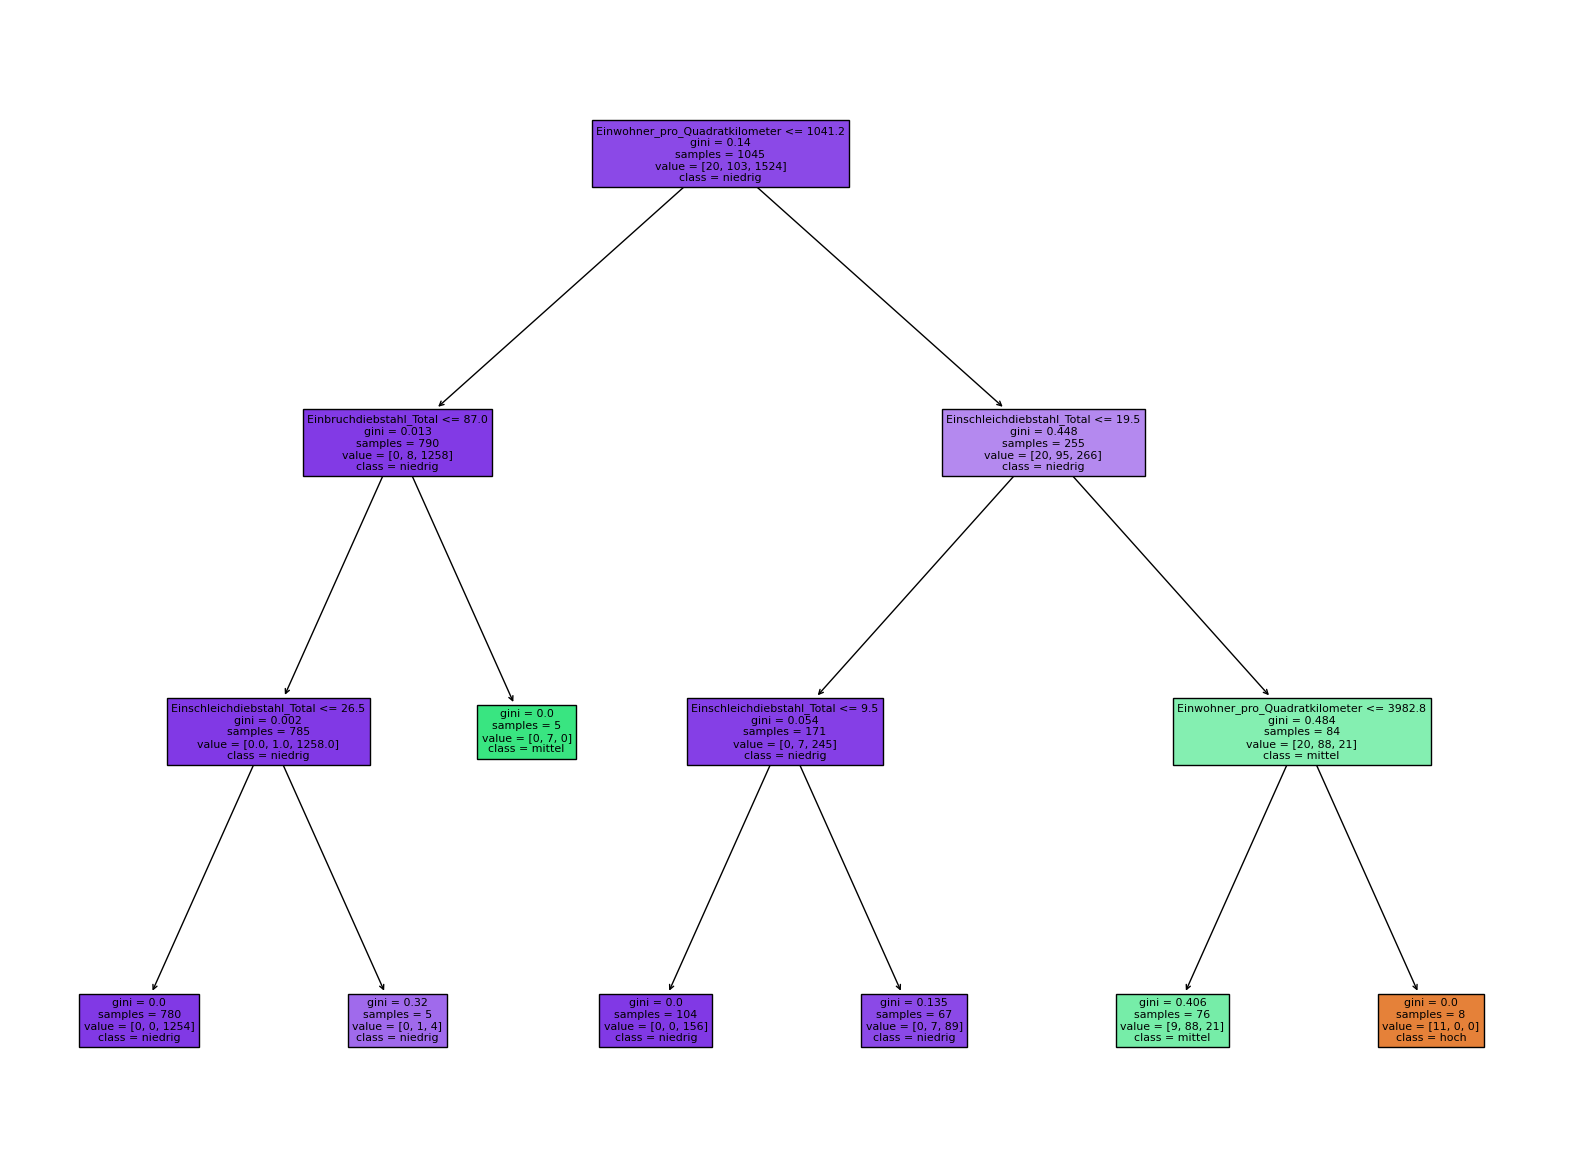

Vorhersagen für die neuen Daten:
['niedrig' 'niedrig' 'niedrig' 'niedrig' 'niedrig' 'niedrig' 'niedrig'
 'niedrig' 'niedrig' 'niedrig' 'niedrig' 'niedrig' 'niedrig' 'niedrig'
 'niedrig' 'niedrig' 'niedrig' 'niedrig' 'niedrig' 'niedrig' 'hoch' 'hoch']

Genauigkeit auf den neuen Daten:
 0.8636363636363636

Präzision auf den neuen Daten:
 0.7477272727272727

Recall auf den neuen Daten:
 0.8636363636363636

F1-Score auf den neuen Daten:
 0.800982800982801


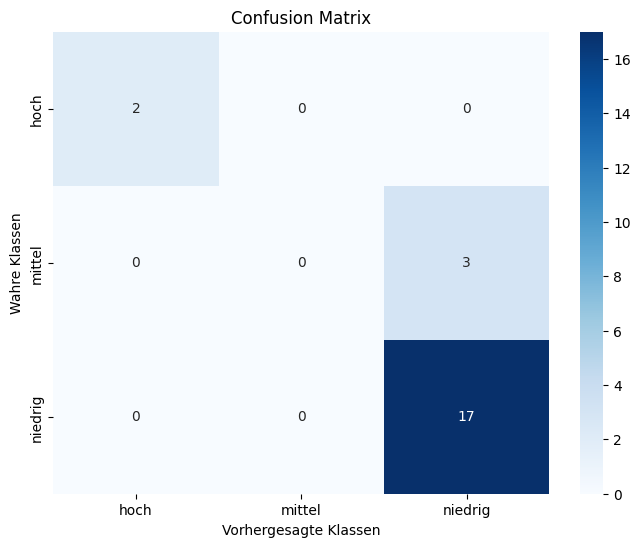

In [25]:
features = ['Einwohner_pro_Quadratkilometer', 'Einbruchdiebstahl_Total', 'Einschleichdiebstahl_Total']
total_crime = df_unique['Einbruchdiebstahl_Total'] + df_unique['Einschleichdiebstahl_Total']
df_unique['Kriminalitätsrisiko'] = pd.cut(total_crime, bins=[-float("inf"), 100, 500, float("inf")], labels=["niedrig", "mittel", "hoch"])
target = 'Kriminalitätsrisiko'

X = df_unique[features]
y = df_unique[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=3)
random_forest.fit(X_train, y_train)

y_pred_random_forest = random_forest.predict(X_test)
plt.figure(figsize=(20, 15))
plot_tree(random_forest.estimators_[0], feature_names=features, class_names=random_forest.classes_, filled=True)
plt.show()

# Neue Daten für Vorhersagen erstellen
new_data = pd.DataFrame({
    'Einwohner_pro_Quadratkilometer': [1800, 2200, 1900, 2100, 2300, 1700, 2000, 2400, 2500, 1600, 
                                        1850, 1950, 2050, 2150, 2250, 2350, 2450, 2550, 1650, 1750, 5600, 7800],  
    'Einbruchdiebstahl_Total': [45, 55, 60, 35, 40, 30, 50, 65, 70, 25,
                                 48, 58, 63, 37, 42, 32, 52, 67, 72, 27, 2000, 1400],                
    'Einschleichdiebstahl_Total': [8, 12, 15, 6, 10, 5, 9, 13, 16, 4, 
                                    9, 11, 14, 7, 11, 6, 10, 14, 17, 3, 88, 190]
})

new_data_predictions = random_forest.predict(new_data)

print("Vorhersagen für die neuen Daten:")
print(new_data_predictions)

new_data_true_labels = ['niedrig', 'niedrig', 'niedrig', 'niedrig', 'niedrig', 'niedrig', 'niedrig',
                        'niedrig', 'mittel', 'niedrig', 'niedrig', 'niedrig', 'niedrig', 'niedrig',
                        'niedrig', 'niedrig', 'mittel', 'mittel', 'niedrig', 'niedrig', 'hoch', 'hoch']  # True labels für die neuen Daten (Beispiel)
new_data_accuracy = accuracy_score(new_data_true_labels, new_data_predictions)
new_data_precision = precision_score(new_data_true_labels, new_data_predictions, average='weighted', zero_division=0)
new_data_recall = recall_score(new_data_true_labels, new_data_predictions, average='weighted')
new_data_f1 = f1_score(new_data_true_labels, new_data_predictions, average='weighted')

print("\nGenauigkeit auf den neuen Daten:\n", new_data_accuracy)
print("\nPräzision auf den neuen Daten:\n", new_data_precision)
print("\nRecall auf den neuen Daten:\n", new_data_recall)
print("\nF1-Score auf den neuen Daten:\n", new_data_f1)

conf_matrix = confusion_matrix(new_data_true_labels, new_data_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=random_forest.classes_, yticklabels=random_forest.classes_)
plt.xlabel('Vorhergesagte Klassen')
plt.ylabel('Wahre Klassen')
plt.title('Confusion Matrix')
plt.show()

##### Interpretation of the results:

Accuracy: The accuracy measures the percentage of correct predictions in relation to the total number of predictions. In this case, the accuracy is 0.8636, which means that the model made about 86.36% of the predictions correctly.

Precision: Precision measures the percentage of correct positive predictions in relation to the total number of positive predictions (correct positives and false positives). Here the precision is 0.7477, which means that about 74.77 % of the positive predictions are actually correct.

Recall: The recall (also known as the true positive rate) measures the percentage of correctly predicted positive instances in relation to the total number of actual positive instances. Here it is 0.8636, which means that the model correctly predicted around 86.36 % of the actual positive instances.

F1 score: The F1 score is the harmonic mean between precision and recall and provides a balanced evaluation between them. It is 0.8010, which shows that the model has a good balance between precision and recall.

### Time Series Prediction using ARIMA

<Figure size 1200x600 with 0 Axes>

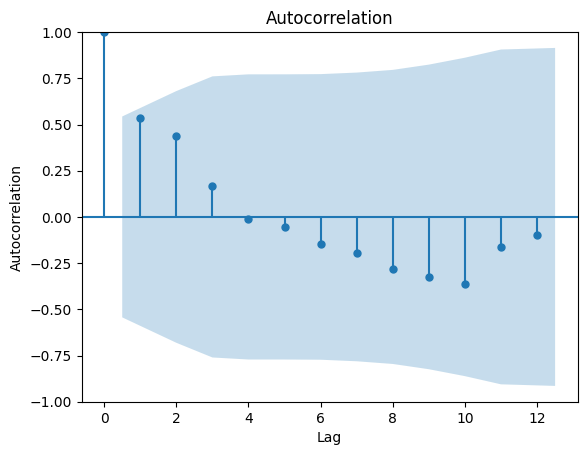

<Figure size 1200x600 with 0 Axes>

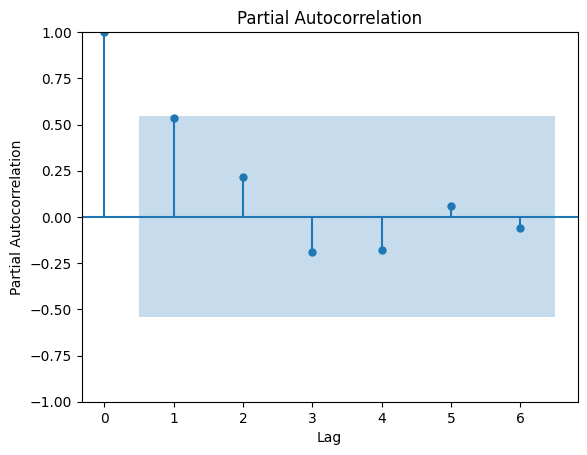

In [26]:

zurich_data = df_unique[df_unique['Gemeindename'] == 'Zürich']
time_series = zurich_data.set_index('Jahr')['Einbruchdiebstahl_Total']

plt.figure(figsize=(12, 6))
plot_acf(time_series, lags=min(12, len(time_series) - 1)) 
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(time_series, lags=min(6, len(time_series) - 1)) 
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


Vorhersage für Zürich für die nächsten 5 Jahre:
 13    2181.0
14    2329.0
15    2365.0
16    2353.0
17    2285.0
Name: predicted_mean, dtype: float64


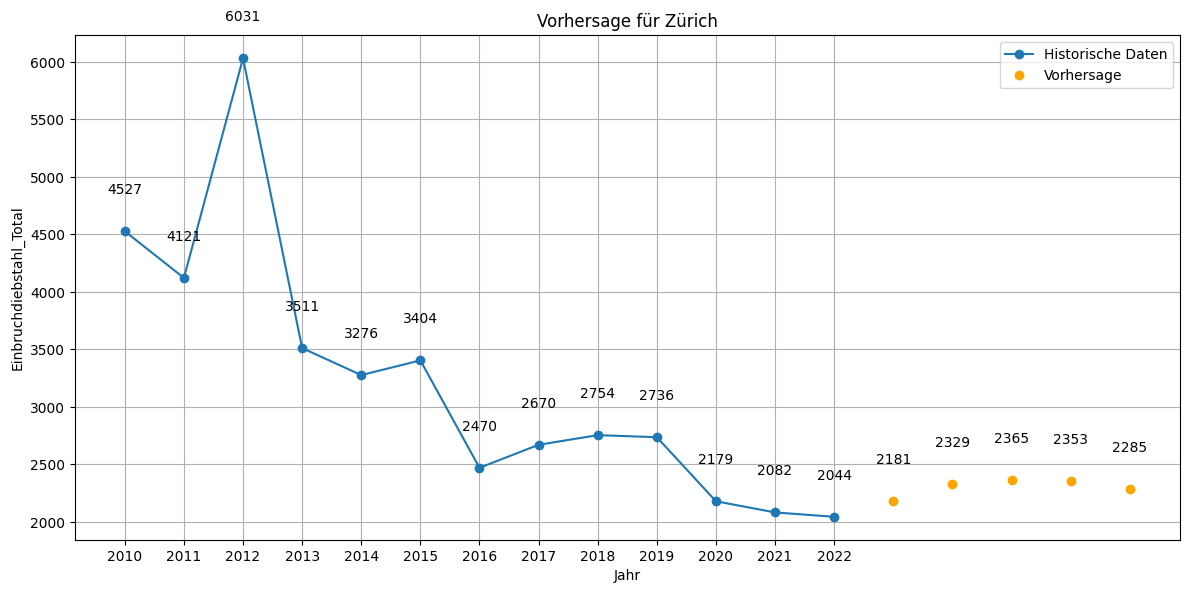

In [27]:

warnings.filterwarnings("ignore")

zurich_data = df_unique[df_unique['Gemeindename'] == 'Zürich']
time_series = zurich_data.set_index('Jahr')['Einbruchdiebstahl_Total']

def arima_forecast(data, order, steps):
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast

n_steps = 5  # Anzahl der Jahre für die Vorhersage
order = (5, 1, 0)  # ARIMA-Modellordnung

forecast = arima_forecast(time_series, order, n_steps)

print("Vorhersage für Zürich für die nächsten", n_steps, "Jahre:\n", forecast.round())

last_year = time_series.index[-1]
forecast_years = range(last_year + 1, last_year + n_steps + 1)

existing_years = time_series.index

plt.figure(figsize=(12, 6))  
plt.plot(existing_years, time_series.values, label='Historische Daten', marker='o')
plt.plot(forecast_years, forecast.round(), 'o', label='Vorhersage', color='orange')

plt.xlabel('Jahr')
plt.ylabel('Einbruchdiebstahl_Total')
plt.title('Vorhersage für Zürich')
plt.xticks(range(int(time_series.index.min()), int(time_series.index.max()) + 1,))  # Ganzzahlige X-Achsenbeschriftungen
plt.legend()
plt.grid(True)  
plt.tight_layout() 

for year, value in zip(existing_years, time_series.values):
    plt.text(year, value + 0.05 * max(time_series), f'{int(value)}', ha='center', va='bottom')

for year, value in zip(forecast_years, forecast.round()):
    plt.text(year, value + 0.05 * max(time_series), f'{int(value)}', ha='center', va='bottom')

plt.show()

### Regression Modelling for the age groups

Linear Regression:
Mean Absolute Error (MAE): 37.13194506552267
Mean Squared Error (MSE): 4338.526955021418
Root Mean Squared Error (RMSE): 65.86749543607543
R^2 Score: 0.9549557405090872


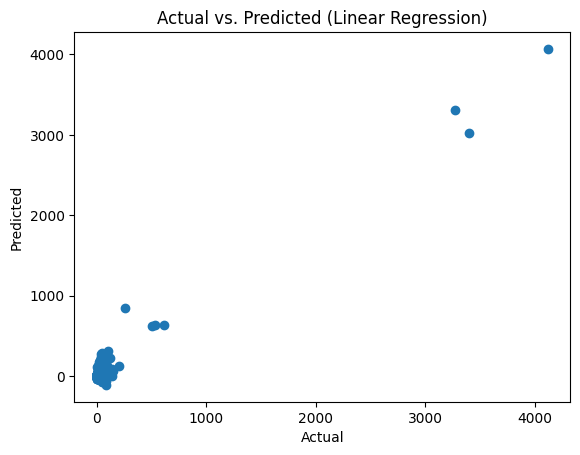

In [28]:

features = ['Einwohner 45-59 Jahre alt', 'Einwohner 60-74 Jahre alt','Einwohner 75-89 Jahre alt']
target = 'Einbruchdiebstahl_Total'

X = df_unique[features]
y = df_unique[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_regr = LinearRegression()
linear_regr.fit(X_train, y_train)
linear_y_pred = linear_regr.predict(X_test)

linear_mae = mean_absolute_error(y_test, linear_y_pred)
linear_mse = mean_squared_error(y_test, linear_y_pred)
linear_rmse = mean_squared_error(y_test, linear_y_pred, squared=False)
linear_r2 = r2_score(y_test, linear_y_pred)

print("Linear Regression:")
print("Mean Absolute Error (MAE):", linear_mae)
print("Mean Squared Error (MSE):", linear_mse)
print("Root Mean Squared Error (RMSE):", linear_rmse)
print("R^2 Score:", linear_r2)

plt.scatter(y_test, linear_y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted (Linear Regression)")
plt.show()


SGD Regression:
Mean Absolute Error (MAE): 8135850318185579.0
Mean Squared Error (MSE): 5.8510361086927285e+32
Root Mean Squared Error (RMSE): 2.4188915041176876e+16
R^2 Score: -6.074771264602068e+27


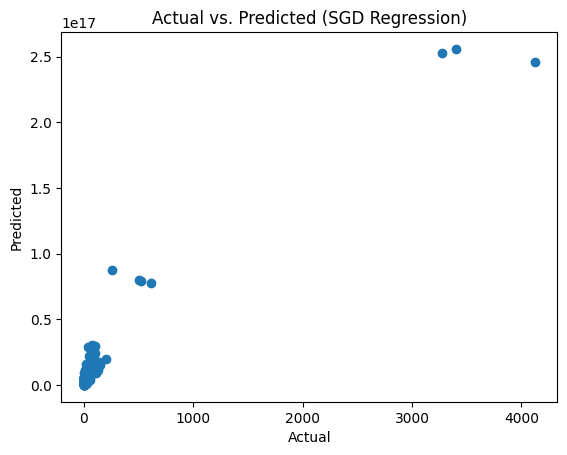

In [29]:
features = ['Einwohner 45-59 Jahre alt', 'Einwohner 60-74 Jahre alt','Einwohner 75-89 Jahre alt']
target = 'Einbruchdiebstahl_Total'

X = df_unique[features]
y = df_unique[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sgd_regr = SGDRegressor(max_iter=200, eta0=0.01)
sgd_regr.fit(X_train, y_train)
sgd_y_pred = sgd_regr.predict(X_test)

sgd_mae = mean_absolute_error(y_test, sgd_y_pred)
sgd_mse = mean_squared_error(y_test, sgd_y_pred)
sgd_rmse = mean_squared_error(y_test, sgd_y_pred, squared=False)
sgd_r2 = r2_score(y_test, sgd_y_pred)

print("SGD Regression:")
print("Mean Absolute Error (MAE):", sgd_mae)
print("Mean Squared Error (MSE):", sgd_mse)
print("Root Mean Squared Error (RMSE):", sgd_rmse)
print("R^2 Score:", sgd_r2)

plt.scatter(y_test, sgd_y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted (SGD Regression)")
plt.show()

In [30]:
print("Linear Regression:")
print("Mean Absolute Error (MAE):", linear_mae)
print("Mean Squared Error (MSE):", linear_mse)
print("Root Mean Squared Error (RMSE):", linear_rmse)
print("R^2 Score:", linear_r2)

print("\nSGD Regression:")
print("Mean Absolute Error (MAE):", sgd_mae)
print("Mean Squared Error (MSE):", sgd_mse)
print("Root Mean Squared Error (RMSE):", sgd_rmse)
print("R^2 Score:", sgd_r2)


Linear Regression:
Mean Absolute Error (MAE): 37.13194506552267
Mean Squared Error (MSE): 4338.526955021418
Root Mean Squared Error (RMSE): 65.86749543607543
R^2 Score: 0.9549557405090872

SGD Regression:
Mean Absolute Error (MAE): 8135850318185579.0
Mean Squared Error (MSE): 5.8510361086927285e+32
Root Mean Squared Error (RMSE): 2.4188915041176876e+16
R^2 Score: -6.074771264602068e+27


Based on these metrics, linear regression appears to perform better than SGD regression. The SGD regression probably achieved poor results due to model parameters or training problems.

Mean Absolute Error (MAE): 37.13
An MAE of 37.13 means that the average deviation between actual and predicted burglaries is approximately 37.13.

R^2 Score: 0.955
An R^2 score of 0.955 means that about 95.5% of the variation in the number of burglaries is explained by the model. A high R^2 score indicates that the model explains the data well.

In [31]:
coefficients = linear_regr.coef_

for feature, coefficient in zip(features, coefficients):
    print(f"{feature}: {coefficient}")

Einwohner 45-59 Jahre alt: -0.041171094763051516
Einwohner 60-74 Jahre alt: -0.10753611649094409
Einwohner 75-89 Jahre alt: 0.3980276012312389


Resisdents 45-59 years old (-0.0411): A negative coefficient for this age group indicates that an increase in the population in the 45-59 age group is associated with a decrease in the number of burglaries. It is possible that people in this age group are more likely to work and spend less time at home, which could lead to less presence and surveillance in the neighborhood.

Residents 60-74 years old (-0.1075): Similarly, a negative coefficient for this age group indicates that an increase in the population in the 60-74 age group is associated with a decrease in the number of burglaries. People in this age group tend to spend more time at home and may show increased vigilance to potential dangers in their environment.

Residents 75-89 years old (0.3980): The positive coefficient for this age group suggests that an increase in the population in the 75-89 age group is associated with an increase in the number of burglaries. This could suggest that areas with an older population may be more prone to burglary, possibly due to lower mobility or surveillance ability of older people.